In [1]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,'/media/DATA/jbonato/astro_segm/RASTA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


### parameter for roi fractioning during extraction
MAX_ROI_AREA_PROC=30
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True


In [2]:
#PARAMS
N=1024
M=1024

fov_list = [2]
fov_DNN_weights_folder = '/media/DATA/jbonato/astro_segm/weights/dense_up' 
set_dir='/media/DATA/jbonato/astro_segm/set1/'

In [3]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False

##### LOAD PARAM DICT
# with open(set_dir+'.tmp/dict_dataset1.txt', "rb") as fp:   #Pickling
#     dict_param = pickle.load(fp)
    
    
dict_param = {
    'list':[0,40,80,120,160],
    'blocks':15,
    'threads':32,
    'BPM_ratio':3,
    'bb':96,
    
    'N_pix_st':100, #starting minimum area
    'astr_min':80, # approx. 0.9 min in dataset
    'percentile': 80,
    'pad':5,
    'astro_num':4, # number of astro min in FOV
    'init_th_':0.6, # threshold initialization
    'decr_dim':10, # astro area decrease
    'decr_th':25, # temporal threshold decrease
    'corr_int':False, # intensity correction flag
    'gpu_flag':True
}
dict_param['percentile']=80
dict_param['max_min'] = np.asarray([345,89])
max_min = dict_param['max_min']

dict_param['th1_p']=0.25
dict_param['th2_p']=0.1

dict_param['list']=[i*32 for i in range(30)]
dict_param['astro_num']=16*4
# dict_param['iter_block']=6
dict_param

{'list': [0,
  32,
  64,
  96,
  128,
  160,
  192,
  224,
  256,
  288,
  320,
  352,
  384,
  416,
  448,
  480,
  512,
  544,
  576,
  608,
  640,
  672,
  704,
  736,
  768,
  800,
  832,
  864,
  896,
  928],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 64,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  89]),
 'th1_p': 0.25,
 'th2_p': 0.1}

In [4]:
# import numpy as np
# from skimage import io
# import matplotlib.pyplot as plt
# import cv2
# #from sklearn.externals.joblib import Parallel, delayed
# from skimage.restoration import denoise_nl_means,estimate_sigma
# from scipy import signal
# from joblib import Parallel, delayed
# import os
# import h5py
# from numba import cuda,float32,uint16,float64,int32,int64  
# import numba
# from numba import types

# class ThScal():
#     def __init__(self,stack):
#         kernel = np.ones((50,50),np.float32)/(50*50)
#         density = cv2.filter2D(np.median(stack,axis=0),-1,kernel)
#         self.density = density/np.amax(density)
        
#     def ThMat(self,ff,th_):
#         N,M = ff.shape
#         mask_th = th_*np.ones((N,M))
        
#         cnt=1
#         for i in [0.6,0.4,0.2,0]:
#             buff = self.density.copy()
#             buff[buff<i]=0
#             buff[buff>=i+0.2]=0
#             buff[buff>0]=1
#             mask_th-=buff*(th_*0.05*cnt)
#             cnt+=1

#         ff[ff<mask_th]=0
#         ff[ff>0]=1
#         return ff

# @cuda.jit#("void(int64,int64,float64[:,:,:],int32[:,:,:],int32[:,:],int32[:,:],int64,int64,int64)")#",int32,int32,int32)")
# def sel_active_gpu(bz,time_ref,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block):
#     #clean code 32 with step 5 with cycle 928 with step*cycle*iter-step
#     size = cuda.gridDim.x
#     cycle = size//3
#     b_dimx = cuda.blockDim.x
#     b_dimy = cuda.blockDim.y
    
#     bx = cuda.blockIdx.x  
#     by = cuda.blockIdx.y
            
#     tx = cuda.threadIdx.x
#     ty = cuda.threadIdx.y

#     for it_bk in range(6):
#         for it_bk_y in range(6):
        
#             if it_bk*32*5+((bx//BPM_ratio)*stp)<=928 and it_bk_y*32*5+((by//BPM_ratio)*stp)<=928:

#                 if stack[bz,it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz+time_ref,it_bk*5+bx//BPM_ratio,it_bk_y*5+by//BPM_ratio]:
#                     cuda.atomic.add(im_out,(it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

#                 if bz ==0 and time_ref==0:
#                     cuda.atomic.add(cover,(it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)


# class sel_active_reg():
    
#     def __init__(self,stack,dict_params,verbose=True,static=False):
#         self.stack = stack
#         self.step_list = dict_params['list']
#         if len(self.step_list)==1:
#             self.stp=1
#         else:
#             self.stp = self.step_list[1]-self.step_list[0]
#         self.blocks = dict_params['blocks']
#         self.threads = dict_params['threads']
#         self.BPM_ratio = dict_params['BPM_ratio'] # # of block inside a patch
#         self.bb = dict_params['bb']

#         self.N_pix_st = dict_params['N_pix_st']
#         self.astr_min = dict_params['astr_min']
#         self.per_tile = dict_params['percentile']
#         self.astro_num = dict_params['astro_num']
#         self.init_th_ = dict_params['init_th_']
#         self.decr_dim = dict_params['decr_dim']
#         self.decr_th = dict_params['decr_th']
#         self.corr_int = dict_params['corr_int']
#         self.gpu_flag = dict_params['gpu_flag']
#         self.static = static
#         self.verbose = verbose
#         self.iter_block = dict_params['iter_block']
#         print('BLOCKS',self.iter_block)
#         self.gpu_num = 0
        
#     @staticmethod
#     def percent_matrix_par(stack,t,listx,bb,per_tile):
#         listy = listx
#         dim = len(listx)
#         matrix= t*np.ones((dim+1,dim),dtype=np.float32)

#         for i in range(dim):
#             for j in range(dim):

#                 x = listx[i] 
#                 y = listy[j]
#                 matrix[i,j] = np.percentile(stack[t,x:x+bb,y:y+bb],per_tile)  

#         return matrix.astype(np.float32) 

#     def sel_active_cpu(self):

#         T,N,M = self.stack.shape
#         T,N,M = stack.shape

#         percent_list = Parallel(n_jobs=-1,verbose=0)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
#         percentiles = np.asarray(percent_list)
#         mat_per = percentiles[:,:-1,:]
#         mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]

#         im_out = np.empty((T,N,M)) 
#         cover = np.zeros((T,N,M)) 
#         for i in range(T):
#             for x in self.listx:
#                 for y in self.listy:

#                     buffer_im = self.stack[i,x:x+self.bb,y:y+self.bb]-mat_per[i,x//self.stp,y//self.stp]
#                     buffer_im[buffer_im<0]=0.
#                     buffer_im[buffer_im>0]=1.

#                     im_out[i,x:x+self.bb,y:y+self.bb]+=buffer_im
#                     cover[i,x:x+self.bb,y:y+self.bb]+=1


        
#         self.mask_tot = np.empty_like(im_out)
#         self.mask_tot  = im_out/cover 
    
#     def sel_active_reg_gpu(self):

#         T,N,M = self.stack.shape
#         cuda.select_device(self.gpu_num)    

#         threadsperblock = (self.threads,self.threads)
#         blockspergrid = (self.blocks,self.blocks)
            
#         if self.verbose: print('Computing local thresholds')
#         # compute percentile in patches
#         if not(self.static):
#             percent_list = Parallel(n_jobs=-1)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
#             percentiles = np.asarray(percent_list).astype(np.float32)
#             mat_per = percentiles[:,:-1,:]

#             mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]# reorder the embarasing parallel collection of mat
            
#         #### mod for static fluorophore
#         # compute a single percentile for all the stack, and than generate a T x num_patch x num_patch 
#         elif self.static:
#             mat_per = np.percentile(self.stack.flatten(),self.per_tile).reshape(1,1)
#             mat_per = np.tile(mat_per,(T,1,1))
            
            
#         #mat_per = np.zeros((T,len(self.step_list),len(self.step_list)))#,dtype=np.int32   
#         ### allocate percentile matrix
#         if self.verbose: print('GPU started')
#         mat_per_g = cuda.to_device(mat_per) 
#         ### allocate in ram
#         im_out = np.zeros((N,M),dtype=np.int32)
#         cover = np.zeros((N,M),dtype=np.int32)
#         ### allocate and load in DRAM
#         im_out_g = cuda.to_device(im_out)
#         cover_g = cuda.to_device(cover)
#         #iter_block_gpu = cuda.to_device(self.iter_block)
#         blocks_to_load =[i*1000 for i in range((T//1000)+1)]
#         blocks_to_load.append(T)
       
#         for stps in range(len(blocks_to_load)-1):
#             stack_gpu = cuda.to_device(self.stack[blocks_to_load[stps]:blocks_to_load[stps+1],:,:])
#             for bz in range(blocks_to_load[stps+1]-blocks_to_load[stps]):
#                 sel_active_gpu[blockspergrid, threadsperblock](bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block)
#             ### free from old stack
#             del stack_gpu

#         im_out = im_out_g.copy_to_host()
#         cover = cover_g.copy_to_host()
#         if self.verbose: print('GPU done')
#         del im_out_g, cover_g, mat_per_g
        
#         self.mask_tot = np.empty_like(im_out).astype(np.float64)
#         self.mask_tot  = im_out.astype(np.float64)/cover.astype(np.float64) 
#         return im_out,cover 
    
#     def get_mask(self,find_round=True):
#         T,_,_ = self.stack.shape
        
#         if self.gpu_flag:
#             self.sel_active_reg_gpu()
#         else:
#             self.sel_active_reg_cpu()
    
#         if self.corr_int:
#             scaling = ThScal(self.stack)

       
#         th_ =round(T*self.init_th_)
        
#         if find_round:
#             #this is an alternative strategy to select the strating point threshold the nearest to th_, it is a seed for the while below 
#             #this strategy can be removed and th_ will be the T*self.init_th_ and not one of the seed points below
#             # we used this strategy for dataset-1, this approach reduces large variation in th_ due to small variation in self.init_th_
#             if T>500: 
#                 th_list = [200,250,300,350,400,450,500,550,600,650,700]
#                 th_list = (T//500)*np.asarray(th_list)
#                 th_ref =th_list-th_
#                 th_ = th_list[np.argmin(np.abs(th_ref))]
#         cnt=0
#         #print(th_)
#         starting_th = th_
#         flag_th=True
#         N_pix = self.N_pix_st
        
#         while(cnt<self.astro_num and N_pix>=self.N_pix_st*0.3 and th_>round(T*0.3)):
#             if flag_th:
#                 mask_tot_s = self.mask_tot.copy()#np.sum(,axis=0)

#                 if self.corr_int:
#                     mask_tot_s = scaling.ThMat(mask_tot_s,th_)
#                     mask_tot_s= np.uint8(mask_tot_s)
#                 else:
#                     mask_tot_s[mask_tot_s<=th_]=0
#                     mask_tot_s[mask_tot_s>0.5]=255
#                     mask_tot_s= np.uint8(mask_tot_s)  
#                     self.uuu = mask_tot_s

#                 ret, labels_r = cv2.connectedComponents(mask_tot_s)
#                 flag_th = False

#             labels = labels_r.copy()
#             cnt=0
#             for i in range(1, ret):
#                 pts =  np.where(labels == i)    

#                 if len(pts[0]) < N_pix:

#                     labels[pts] = 0
#                 else:
#                     cnt+=1

#                     labels[pts] = 255         

#             N_pix-=self.decr_dim
#             if N_pix<=self.astr_min and (starting_th-th_)<105:

#                 th_-=self.decr_th
#                 flag_th = True  
#                 N_pix=self.N_pix_st

#         # clean eventual artifacts
#         ret, labels = cv2.connectedComponents(np.uint8(labels))
#         el_rem_LS = 0
#         for i in range(1, ret):
#             pts =  np.where(labels == i)    
#             if len(pts[0])<self.astr_min//4:
#                 labels[pts]=0
#                 el_rem_LS+=1
        
#         if self.verbose:
#             print('Zones identified inside the FOV',ret-el_rem_LS)
        
#         labels[labels>0]=1
#         return labels


In [5]:
### Gen meso image
# stack = io.imread('/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff').astype(np.uint16)
# T,N,M = stack.shape
# meso_stack = np.empty((4*T,4*N,4*M),dtype=np.uint16)
# for i in range(4):
#     for k in range(4):
#         meso_stack[:,i*N:i*N+N,k*M:k*M+M] = np.tile(stack,(4,1,1))
# print(meso_stack.shape)     
# io.imsave('/media/DATA/jbonato/astro_segm/notebook/dev/meso_test.tiff',meso_stack)
# del meso_stack
# # plt.imshow(np.median(meso_stack,axis=0))

In [6]:
# print("%d bytes" % (meso_stack.size * meso_stack.itemsize/1000000))

# test_st = np.zeros((1000,1024,1024),dtype=np.int32)
# print("%d bytes" % (test_st.size * test_st.itemsize/1000000))
# c0 = time.time()
# print(test_st[0,:,:].data.contiguous) 
# for i in range(1000):
#     c = np.percentile(test_st[i,:,:],10)
# c1 = time.time()
# print(c1-c0)
# test_st = np.zeros((1024,1024,1000),dtype=np.int32)
# print("%d bytes" % (test_st.size * test_st.itemsize/1000000))

# c0 = time.time()
# print(test_st[:,:,0].data.contiguous) 
# for i in range(1000):
#     c = np.percentile(test_st[:,:,i],10)
# c1 = time.time()
# print(c1-c0)




In [7]:
# def create_bb_coord(soma_mask,BB_dim):
#     #use even BB_dim
#     ################################################
#     #    0------------------------>x
#     #    |
#     #    |
#     #    |     MATRICES
#     #    |
#     #    y
#     ################################################
#     N,M= soma_mask.shape
#     soma = np.empty_like(soma_mask)
#     soma = soma_mask.copy()
#     soma[soma>0.1]=255
#     BBh = BB_dim//2
   
#     # convert the grayscale image to binary image
#     _,thresh = cv2.threshold(np.uint8(soma),127,255,0)
    
#     # find contours in the binary image
#     contours, _= cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#     # loop over the contours
#     #list of array with the coordinate
#     coord_list=[]
#     filt_im_zone = np.zeros((N,M,len(contours)))
#     cnt=0    
#     for c in contours:
#         # compute the center of the contour
#         filt_= np.zeros((N,M))
#         Mom = cv2.moments(c)
#         cX = int(Mom["m10"] / Mom["m00"])
#         cY = int(Mom["m01"] / Mom["m00"])
#         #print(cX,cY)
#         cv2.circle(filt_,(cX,cY),43,255,thickness = -1,lineType=8)
#         filt_im_zone[:,:,cnt]=filt_
#         cnt+=1

#         casex=2
#         casey=2
#         if cX-BBh<0:
#             casex=0
#         elif cX+BBh>M:
#             casex=1
#         if cY-BBh<0:
#             casey=0
#         elif cY+BBh>N:
#             casey=1
#         #x
#         if casex==2:
#             c1x=cX-BBh
#             c2x=cX+BBh
#         elif casex==0:
#             c1x=0
#             c2x=BB_dim
#         else:
#             c1x=M-BB_dim
#             c2x=M
#         #y
#         if casey==2:
#             c1y=cY-BBh
#             c2y=cY+BBh
#         elif casey==0:
#             c1y=0
#             c2y=BB_dim
#         else:
#             c1y=N-BB_dim
#             c2y=N
        
#         coord = np.array([c1x,c1y,c2x,c2y])
#         #print(coord)
#         coord_list.append(coord)
#     filt_im_zone[filt_im_zone>0]=1
#     #print(len(coord_list))
#     return coord_list,filt_im_zone

In [8]:
# import time 

# class spatial_pp():
#     def __init__(self,file=None,file_path=None):
#         if file is None:
#             self.stack = io.imread(file_path)
#         elif file_path is None:
#             self.stack = file
            
#     @staticmethod
#     def clean_stack(frame,i):
#         return [np.percentile(frame,10).astype(np.int32),i]
    
#     @staticmethod
#     def median_par(stack,perc,i):
#         stack = stack-perc[:,np.newaxis,np.newaxis]
#         stack[stack<0]=0
#         return [np.median(stack,axis=0),i]
    
#     def create_img(self,T_st=0):

#         #_,N,M = self.stack.shape
        
#         if T_st==0:
#             self.stack = self.stack.astype(np.int32)
#         else:
#             self.stack = self.stack[:T_st,:,:].astype(np.int32)
            
#         #stack_new = self.stack.copy()

#         T,N,M = self.stack.shape
#         conv_im = np.empty((N,M))
#         perc = np.zeros((T))
        
#         list_frame = Parallel(n_jobs=-1,verbose=1,require='sharedmem')(delayed(self.clean_stack)(self.stack[i,:,:],i) for i in range(T))
#         for el in list_frame:
#             perc[el[1]] = el[0]
      
#         del list_frame
# #         for t in range(T):
# #             stack_new[t,:,:] = stack_new[t,:,:] - np.percentile(stack_new[t,:256,:256],10).astype(np.int32)
# #             stack_new[t,:,:][stack_new[t,:,:]<0]=0 
            
# #         stack_new = np.asarray(list_frame).astype(np.int32)
# #         del list_frame
        
#         #conv_im = np.median(stack_new,axis=0) 
#         c1 = time.time()
#         im_out = Parallel(n_jobs=-1,verbose=1,require='sharedmem')(delayed(self.median_par)(self.stack[:,(i//4)*256:(i//4)*256+256,(i%4)*256:(i%4)*256+256],perc,i) for i in range(16))
#         print('bench',time.time()-c1)
        
#         for el in im_out:
#             idx = el[1]
#             conv_im[(idx//4)*256:(idx//4)*256+256,(idx%4)*256:(idx%4)*256+256] = el[0]
        
#         del im_out#,stack_new
        
#         maximum = 65535/np.amax(conv_im) 
        
#         conv_im =conv_im.astype(np.float32)*maximum   
        
        
#         clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(32,32))
#         cl1 = clahe.apply(np.uint16(conv_im))       
        

#         kernel_sharpening = np.array([[-1,-1,-1], 
#                                   [-1, 9,-1],
#                                   [-1,-1,-1]])

#         denoise = np.uint16(cl1)
#         image = cv2.filter2D(np.uint16(cl1), -1, kernel_sharpening)
#         return cl1,image
    
        
#     def create_img_d2(self):
        
#         T,_,_ = self.stack.shape
#         stack_new = np.empty((T,256,256))
#         a = 0
#         for t in range(T):
#             stack_new[t,:,:] = cv2.resize(self.stack[t,:,:],(256,256),interpolation=cv2.INTER_AREA)
            
#         median = np.median(stack_new,axis=0)
#         median = cv2.GaussianBlur(np.uint16(median),(3,3),0)
#         maximum = 65535/np.amax(median)
#         median = median.astype(np.float32)*maximum
        
#         clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(16,16))
#         cl1 = clahe.apply(np.uint16(median))

#         kernel_sharpening = np.array([[-1,-1,-1],
#                                      [-1, 9,-1],
#                                       [-1,-1,-1]])
#         image = cv2.filter2D(np.uint16(cl1), -1, kernel_sharpening)
        
#         return stack_new,image
    
#     def create_img_large(self):

#         self.stack = self.stack[:,2:-3,2:-3]

#         T,N,M = self.stack.shape
#         self.stack = self.stack.astype(np.float32)
        

#         stack_new = np.empty_like(self.stack)
#         for i in range(N):
#             for j in range(M):
                
#                 stack_new[:,i,j]= np.convolve(self.stack[:,i,j],1/5*np.ones((5,)),'same')

#         conv_im = np.mean(stack_new,axis=0)   
#         clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
#         cl1 = clahe.apply(np.uint16(conv_im))       

#         return stack_new,cl1
    



# ###################################################### Inference PP

# class filt_im(spatial_pp):

#     def __init__(self, file, mask_soma,BB_dim,filt_meth='std'):
#         super().__init__(file = file)
#         self.BB_dim = BB_dim   
#         self.mask_soma = mask_soma
#         self.coord_list,self.filt_im_zone = create_bb_coord(mask_soma,BB_dim)
#         print('{} BBs selected inside the FOV'.format(len(self.coord_list)))
#         self.filt_meth = filt_meth
#         assert self.filt_meth =='std' or self.filt_meth=='ad_hoc','Undefined local activity filter'
        
#     def get_instances(self):
#         return self.coord_list

    
#     def filtering(self,stack,th1_p=0.25,th2_p=0.1):
#         T,N,M = stack.shape


#         percent = np.percentile(stack.reshape(T*N*M),90)
#         stack_cp = stack.copy()
#         stack_cp[stack<percent]=0
#         stack_cp[stack>=percent]=1

#         sum_= np.sum(stack_cp,axis=0)
#         th1 = round(T*th1_p)
#         sum_[sum_<th1]=0
#         sum_[sum_>=th1]=1


#         fill_s= np.zeros_like(sum_)
#         fill_s[sum_==0]=1
#         stack_f=stack.copy()*fill_s
#         percent = np.percentile(stack_f.reshape(T*N*M),90)
#         stack_f[stack_f<percent]=0
#         stack_f[stack_f>=percent]=1

#         sum_p =np.sum(stack_f,axis=0)
#         th2 = round(T*th2_p) 
#         sum_p[sum_p<th2]=0
#         sum_p[sum_p>=th2]=1    
#         sum_p+=sum_

#         return sum_p
    
#     def filter_hoc(self,stack,perc=90,th=0.25):

#         T,N,M = stack.shape
#         perc = np.percentile(stack.reshape(T*N*M),perc)
#         mask=stack.copy()
#         mask[mask<perc]=0
#         mask[mask>=perc]=1
#         mask = np.sum(mask,axis=0)
#         th2 = round(T*th) 
#         mask[mask<th2]=0
#         mask[mask>=th2]=1

#         return mask
    
#     @staticmethod
#     def gen_single_im(crop_stack,crop_im,i,filt_meth,pad):
        
#         def filtering(stack,th1_p=0.25,th2_p=0.1):
#             T,N,M = stack.shape


#             percent = np.percentile(stack.reshape(T*N*M),90)
#             stack_cp = stack.copy()
#             stack_cp[stack<percent]=0
#             stack_cp[stack>=percent]=1

#             sum_= np.sum(stack_cp,axis=0)
#             th1 = round(T*th1_p)
#             sum_[sum_<th1]=0
#             sum_[sum_>=th1]=1


#             fill_s= np.zeros_like(sum_)
#             fill_s[sum_==0]=1
#             stack_f=stack.copy()*fill_s
#             percent = np.percentile(stack_f.reshape(T*N*M),90)
#             stack_f[stack_f<percent]=0
#             stack_f[stack_f>=percent]=1

#             sum_p =np.sum(stack_f,axis=0)
#             th2 = round(T*th2_p) 
#             sum_p[sum_p<th2]=0
#             sum_p[sum_p>=th2]=1    
#             sum_p+=sum_

#             return sum_p
        
#         T,N,M = crop_stack.shape

#         crop_mask_filt = filtering(crop_stack)

        
#         out_stack =np.empty((2,N+2*pad,M+2*pad),dtype=np.float32)

#         out_stack[0,:,:] = np.pad(crop_im*crop_mask_filt,pad,'constant').astype(np.float32)
#         out_stack[0,:,:] -= np.mean(out_stack[0,:,:])
#         out_stack[1,:,:] = np.pad(crop_mask_filt,pad,'constant').astype(np.float32)
        
#         return [out_stack,i]
    
    
    
#     def save_im(self,pad=5,stack=None,case=1):
#         if not(stack is None):
#             self.stack = stack
        
#         dim = self.BB_dim
#         out_dim = self.BB_dim + 2*pad
#         #print(out_dim)
#         T,N,M = self.stack.shape
#         if case==1:
#             _,self.im_enh = self.create_img()
#         elif case==2:
#             _,self.im_enh = self.create_img_d2()
#         elif case==3:
#             _,self.im_enh = self.create_img_large()
                    
#         out_stack = np.empty((len(self.coord_list),2,out_dim,out_dim))
#         act_filt =np.zeros((N,M))
        
#         list_out = Parallel(n_jobs=-1,verbose=1,require='sharedmem')(delayed(self.gen_single_im)(self.stack[:,self.coord_list[i][1]:self.coord_list[i][3],self.coord_list[i][0]:self.coord_list[i][2]],self.im_enh[self.coord_list[i][1]:self.coord_list[i][3],self.coord_list[i][0]:self.coord_list[i][2]],i,self.filt_meth,pad) for i in range(len(self.coord_list)))
#         ###recompose
#         ###
#         for res in list_out:
            
#             idx = res[1]
#             out_stack[idx,:,:,:] = res[0]
#             act_filt[self.coord_list[idx][1]:self.coord_list[idx][3],self.coord_list[idx][0]:self.coord_list[idx][2]] += res[0][1,pad:-pad,pad:-pad]
        
#         act_filt[act_filt>1]=1
#         return out_stack,act_filt

In [9]:
# def common_merge_mesoscope(sm_fr,sm_ent):
#     merge = np.zeros_like(sm_fr)
    
#     def merge_masks(i,labels_fr,labels_ent,ret_ent):
        
#         N,M = labels_fr.shape
#         merged = np.zeros((N,M))
        
#         pts =  np.where(labels_fr == i)
#         mask_tmp = np.zeros((N,M))
#         mask_tmp[pts]=1
#         for j in range(1, ret_ent):
#             pts1 = np.where(labels_ent == j)
#             mask_tmp1 = np.zeros((N,M))
#             mask_tmp1[pts1]=1
#             if len(pts1[0])>len(pts[0]):
#                 ref = len(pts[0])
#             else:
#                 ref = len(pts1[0])
#             if np.sum(mask_tmp*mask_tmp1)>0.1*ref:
#                 merged+=mask_tmp
#                 merged+=mask_tmp1
#         return merged
    
#     N,M = sm_fr.shape
#     ret, labels = cv2.connectedComponents(np.uint8(sm_fr))
#     ret1, labels1 = cv2.connectedComponents(np.uint8(sm_ent))
    
    
    
#     out_el = Parallel(n_jobs=-1,verbose=0,require='sharedmem')(delayed(merge_masks)(i,labels,labels1,ret1)for i in range(1, ret))
#     for out in out_el:
#         merge+=out
    
#     merge[merge>1]=1
#     return merge

In [10]:
stack = io.imread('/media/DATA/jbonato/astro_segm/notebook/dev/meso_test.tiff').astype(np.uint16)

In [11]:
stack.shape

(2200, 1024, 1024)

In [15]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'D1.pt'))
    
    #collect stack to analyze
    
    stack_dir = '/media/DATA/jbonato/astro_segm/set1/'+test_folder_str+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    
    #stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    #dict_im['t-series_'+test_folder_str1] = stack
    
    time1 = time.time()
    frames,_,_ = stack.shape

    a_reg = sel_active_reg(stack.astype(np.int32),dict_param)
    A,B = a_reg.sel_active_reg_gpu_gen()
#     mask = a_reg.get_mask()
    
#     ## this function prevents to select BB to close due to selected regions which are too close 
#     mask = fix_mask(mask)
#     ##
   
#     dict_im['Active Regions_'+test_folder_str1] = mask
#     filter_ = filt_im(stack,mask,dict_param['bb']-2*dict_param['pad'])
   
    
#     # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
   
#     coord_l = filter_.get_instances()
    
#     assert coord_l!=0, 'Check Active region extraction module'
    
#     image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

#     image_stack,filt_imageL = filter_.save_im()#select the padding val 5 is default
#     dict_im['Enhanced_'+test_folder_str1] = filter_.im_enh
    
#     image_set = image_stack[:,0,:,:]
#     image_set = image_set[:,np.newaxis,:,:]

#     imageL = filter_.im_enh*filt_imageL
#     imageL-=np.mean(imageL)
#     imageL_set=None
#     for i in range(3):
#         for j in range(3):
#             if imageL_set is None:
#                 imageL_set= imageL[i*256:i*256+512,j*256:j*256+512][np.newaxis,:,:]
#             else:
#                 imageL_set= np.vstack((imageL_set,imageL[i*256:i*256+512,j*256:j*256+512][np.newaxis,:,:]))
#     imageL_set =imageL_set[:,np.newaxis,:,:]
    
#     timePP = time.time()
    
#     model.eval()   # Set model to evaluate mode
#     ######################################## Prob Map
#     test_datasetL = SimDataset_test(imageL_set)
#     test_loader = DataLoader(test_datasetL, batch_size=1, shuffle=False, num_workers=0)
    
#     pred_mean=[]
#     for inputs in test_loader:
#         inputs = inputs.to(device)
#         pred = model(inputs)
#         pred_mean.append(pred.data.cpu().numpy())
#         del pred,inputs
        
#     del test_datasetL,test_loader
#     torch.cuda.empty_cache()
    
#     mean = np.zeros((filter_.im_enh.shape))
#     for i in range(3):
#         for j in range(3):
#             buff = pred_mean[i*3+j][0,:,:,:]
#             maxim = np.amax(buff,axis=0)
#             buff[buff<maxim]=0
#             if i==0 and j==0:
#                 mean[i*256:i*256+512,j*256:j*256+512] = buff[1,:,:]
#             else:
#                 mean[i*256:i*256+512,j*256:j*256+512] = np.maximum(mean[i*256:i*256+512,j*256:j*256+512],buff[1,:,:])

                
#     prob_mapPL,sm_ent = prob_calc(mean,max_min[0],max_min[1])
    
#     #im_list.append([prob_mapPL,'Prob. Map'])
#     dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
#     #im_list.append([sm_ent,'Prob. Map'])
#     dict_im['Prob. Map_'+test_folder_str1] = sm_ent
    
#     ########################################## putative single cell
#     test_dataset_S = SimDataset_test(image_set)
#     test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)

    
#     pred_mean=[]
#     for inputs in test_loader:
#         inputs = inputs.to(device)

#         pred = model(inputs)
#         pred_mean.append(pred.data.cpu().numpy())
#         del inputs,pred
#     del test_dataset_S,test_loader
    
#     torch.cuda.empty_cache()
    
#     for j in range(1,len(pred_mean)):
#         pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

#     prob_map = np.zeros((N,M,2))

#     for i in range(len(coord_l)):
#         mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
#         mean = pred_mean[0][i,:,:,:].copy()
        
#         maxim = np.amax(mean,axis=0)
#         mean[mean<maxim]=0
#         mean[mean>=maxim]=1

#         small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1])) ####remove too small somata segmentated
#         mean[0,:,:]+=small_soma
#         mean[1,:,:]-=small_soma
        
#         coord = coord_l[i]
#         Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
#         Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]



#     Res_1[:,:,0] -= Res_1[:,:,1]
#     Res_1[Res_1<1]=0
#     Res_1[Res_1>0]=1
    
#     timeNN = time.time()
    
#     ######### can be wrapped
    
#     soma_f = common_merge_mesoscope(Res_1[:,:,1],sm_ent)
#     Res_1[:,:,1]=soma_f
    
#     timePP1 = time.time()
    
#     #remove possible artifacts
#     small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False)
#     Res_1[:,:,1]-=small_soma

#     Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
#     Res_1[Res_1<1]=0
#     Res_1[Res_1>0]=1
    
#     timePP2 = time.time()
    
#     #remove extreme large somata 115% of greater size in training set (if there are >2 region of this size stop the removal)
#     #something goes wrong with preprocessing steps or t-series has some problem
#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]
#         # Once eventual extreme large somata are removed somata greater than max size in training set are removed
#         # if there are >2 region greater tah max size stop the removal, something goes wrong with preprocessing
#         #steps or t-series has some problem
#         Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
#         if removal<2:
#             Res_1-=Res_1_filt[:,:,np.newaxis]
#         else:
#             print('Attention: ',removal, ' large somata found')
#     else:
#         print('Attention: ',removal, ' very large somata found')
#     timePP3 = time.time()

#     #remove processes without soma
#     Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
#     Res_1*=Res_1_filt[:,:,np.newaxis]
    
#     dict_im['Final_Mask_'+test_folder_str1] = Res_1
#     print(20*'%')
#     time2 = time.time()
    
#     print(timePP1-timeNN,timePP2-timePP1,timePP3-timePP2,time2-timePP3)
    
#     print('TempoPP',timePP-time1,'TempoNN',timeNN-timePP,'TempoPostoP',time2-timeNN)
    #######################################################################################################
#     #Visualization of images
#     if vis_flag:
#         vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
#         for key in dict_im.keys():
#             if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
#                 image = dict_im[key]
#                 fig, ax = plt.subplots(figsize=(4,4))
#                 ax.imshow(image)
#                 ax.axis('off')
#                 ax.set_title(key)
#                 vis.matplot(fig)
#                 plt.close(fig)
    
#     #### Extraction
#     single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])
#     dict_im = update_dict_DNN(dict_im,single_astro_roi,test_folder_str1,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
#     #### save dict
#     pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff
Computing local thresholds


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:   20.3s finished


GPU started (15, 15) (32, 32) 6.0 928
0
1
2
GPU done


In [ ]:
# # print(A.shape)
# plt.figure(figsize=(20,20))
# # plt.imshow((A/B)>0.5*550)
# #,sm_ent
# plt.imshow(Res_1)

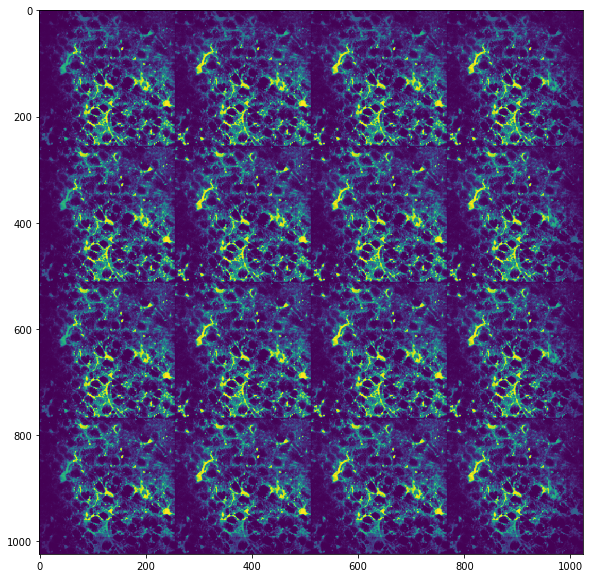

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(A)


In [16]:
video_or = io.imread('/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff')

In [ ]:
def create_img(stack):
    stack_new = stack.copy()
    T,N,M = stack_new.shape
    conv_im = np.empty((N,M))
    t0 = time.time()
    list_per = []
    for t in range(T):
        list_per.append(np.percentile(stack_new[t,:256,:256],10))
        stack_new[t,:,:] = stack_new[t,:,:] - np.percentile(stack_new[t,:256,:256],10)
        stack_new[t,:,:][stack_new[t,:,:]<0]=0 

    t1= time.time()
    conv_im = np.median(stack_new,axis=0) 
    t1b= time.time()
    print(np.amax(conv_im))
    maximum = 65535/np.amax(conv_im) 
    t1bb= time.time()
    conv_im =conv_im.astype(np.float32)*maximum   
    t2= time.time()
    print(t1b-t1,t1bb-t1b,t2-t1bb)
    if N==1024:
        clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(32,32))
        cl1 = clahe.apply(np.uint16(conv_im))       
        t3= time.time()
    else:
        clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
        cl1 = clahe.apply(np.uint16(conv_im))       
        t3= time.time()

    kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])

    denoise = np.uint16(cl1)
    image = cv2.filter2D(np.uint16(cl1), -1, kernel_sharpening)
    t4= time.time()
    print('time',t1-t0,'Norm',t2-t1,'clahe',t3-t2,'ker',t4-t3)
    return stack_new,image,np.asarray(list_per)

In [ ]:
A,B,ll = create_img(video_or)

C,D,ll1 = create_img(stack)

In [ ]:
plt.plot(np.arange(550),ll-ll1)

[    0     1     2 ... 65533 65534 65535]


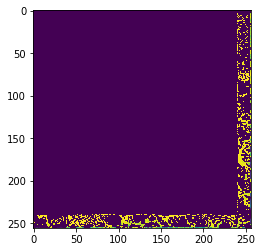

In [78]:
test = D[:256,:256]-B

plt.imshow(test)
print(np.unique(test))

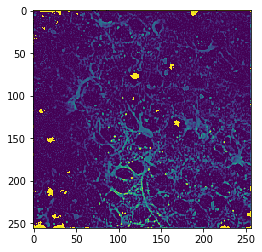

In [79]:
plt.imshow(B)

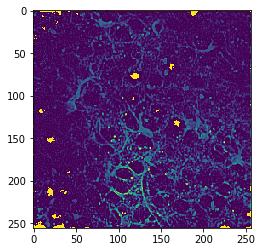

In [80]:
plt.imshow(D[:256,:256])

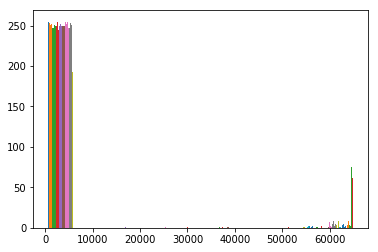

In [81]:
_ = plt.hist(D[:256,:256]-B)

# Visualization of results

In [ ]:
fov_name = []
for j in fov_list:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

# Manual curation
Export ROIs for ImageJ

In [6]:
from ROI_manual_curation import *

In [7]:
#export ROIs for ImageJ
export_roi(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')

FOV 002


In [8]:
#clean dictionary from ROIs and extracted traces
dict_im = clean_dict(dict_im,fov_list)

In [9]:
#update dict_im with the manual curated
for fov in fov_list:
    folder = f'{str(fov):0>3}'
    mask_ret = read_roi_curated(folder,N=256,M=256,folder_read='/media/DATA/jbonato/astro_segm/notebook/')
    dict_im = update_dict_DNN(dict_im,mask_ret,folder,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

NUM ROI 5
ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (256, 256, 24)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 4
SPLIT DONE (256, 256, 9)
Extraction: done
